In [1]:
# Ячейка обязательная, если запускать в коллабе, чтобы файле сохранились на диске
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [3]:
!pip install bigartm10

In [4]:
%matplotlib inline
import glob
import os
import matplotlib.pyplot as plt

import artm

import pandas as pd
import seaborn as sns

import numpy as np

### 1. BatchVectorizer

Before starting modeling we need to convert you data in the library format. At first you need to read about supporting formats for source data in Input Data Formats and Datasets. It’s your task to prepare your data in one of these formats. As you had transformed your data into one of source formats, you can convert them in the BigARTM internal format (batches of documents) using BatchVectorizer class object.

The built-in library parser converted your data into batches and covered them with the BatchVectorizer class object, that is a general input data type for all methods of Python API. The batches were places in the directory, you specified in the target_folder parameter.

In [5]:
# Подключаем ту папку lenta_ts, к файлам которой мы предварительно добавили метки времени
batch_vectorizer = None
if len(glob.glob(os.path.join('batches_ts', '*.batch'))) < 1:
  batch_vectorizer = artm.BatchVectorizer(data_path='lenta_ts', data_format='bow_uci',
                                                collection_name='lenta_ts', target_folder='batches_ts')
else:
  batch_vectorizer = artm.BatchVectorizer(data_path='batches_ts', data_format='batches')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### 2. Dictionary

The next step is to create Dictionary. This is a data structure containing the information about all unique tokens in the collection. The dictionary is generating outside the model, and this operation can be done in different ways (load, create, gather). The most basic case is to gather dictionary using batches directory. You need to do this operation only once when starting working with new collection.

Dictionary is the object of BigARTM, containing the information about the collection (vocabulary, different counters and values, linked to tokens). Provided dictionary will be used for \Phi matrix initialization. It means:


In [6]:
if not os.path.isfile('batches_ts/my_dictionary.dict'):
  dictionary = artm.Dictionary()
  dictionary.gather(data_path='batches_ts')
  dictionary.save(dictionary_path='batches_ts/my_dictionary')
  dictionary.load(dictionary_path='batches_ts/my_dictionary.dict')
else:
  dictionary = artm.Dictionary()
  dictionary.load(dictionary_path='batches_ts/my_dictionary.dict')

### 3. Parameters

In [7]:
# Нужно перебирать параметры и проверять оценки метрик
parameters = {
    'num_topics': 200,
    'num_back_topics': 20,
    'num_collection_passes': 20,
    'num_document_passes': 1,
    'SparsePhiRegularizer': -0.15,
    'SmoothPhiRegularizer': 0.15,
    'SparseThetaRegularizer': -0.1,
    'SmoothThetaRegularizer': 0.1,
    'DecorrelatorPhiRegularizer': 0.25,
    'TopicSelectionThetaRegularizer': 0.0,
    'LabelSparsePsiRegularizer': -0.05,
    'LabelSmoothPsiRegularizer': 0.0,
    'TimestampsClassWeight': 5
}

In [8]:
num_topics = parameters['num_topics']
num_back_topics = parameters['num_back_topics']
num_collection_passes = parameters['num_collection_passes']
num_document_passes = parameters['num_document_passes']
timestamps_class_weight = parameters['TimestampsClassWeight']

topic_names = ['@topic_'+str(i) for i in range(num_topics)]

subj_topics = topic_names[:-num_back_topics]
back_topics = topic_names[-num_back_topics:]

In [9]:
model_artm = artm.ARTM(topic_names=topic_names, cache_theta=True)

model_artm.initialize(dictionary=dictionary)

tokens_class = "@default_class"
timestamps_class = "@timestamps_class"
model_artm.class_ids = {tokens_class: 1.0, timestamps_class: timestamps_class_weight}

### 4. Regularizers
- **Smooth/Sparse Phi:** sparse subject topics to increase their quality and smooth background topics to gather there all background tokens, create two regularizers, specify topic_names parameters with corresponding list in both ones and set tau in sparsing regularizer to some negative value, and in smoothing to some positive one;
- **Smooth/Sparse Theta:** divide all topics into two groups (subject and background), sparse subject topics to increase their quality and smooth  background topics to gather there all background tokens: create two;
- **Decorrelator Phi:** deal only with the tokens of given modality: set class_ids parameter the list with names of modalities to use in this regularizer.

In [10]:
# Smooth/Sparse Phi
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhiRegularizer',
                                                           tau=parameters['SparsePhiRegularizer'],
                                                           topic_names=subj_topics))

model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SmoothPhiRegularizer',
                                                           tau=parameters['SmoothPhiRegularizer'],
                                                           topic_names=back_topics))
# Decorrelator Phi
model_artm.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhiRegularizer',
                                                           tau=parameters['DecorrelatorPhiRegularizer'],
                                                           topic_names=subj_topics,
                                                           class_ids=[tokens_class]))
# TopicSelectionThetaRegularizer
model_artm.regularizers.add(artm.TopicSelectionThetaRegularizer(name='TopicSelectionThetaRegularizer',
                                                               tau=parameters['TopicSelectionThetaRegularizer'],
                                                               topic_names=subj_topics))

# Smooth/Sparse Theta
model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseThetaRegularizer',
                                                             tau=parameters['SparseThetaRegularizer'],
                                                             topic_names=subj_topics))
model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SmoothThetaRegularizer',
                                                             tau=parameters['SmoothThetaRegularizer'],
                                                             topic_names=back_topics))

# LabelSparsePsiRegularizer
model_artm.regularizers.add(artm.LabelRegularizationPhiRegularizer(name='LabelSparsePsiRegularizer',
                                                                  tau=parameters['LabelSparsePsiRegularizer'],
                                                                  topic_names=subj_topics,
                                                                  class_ids=[timestamps_class]))
model_artm.regularizers.add(artm.LabelRegularizationPhiRegularizer(name='LabelSmoothPsiRegularizer',
                                                                  tau=parameters['LabelSmoothPsiRegularizer'],
                                                                  topic_names=back_topics,
                                                                  class_ids=[timestamps_class]))



### 5. Add scores

In [11]:
model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore',
                                               dictionary=dictionary))
model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore',
                                            probability_mass_threshold=0.3))
model_artm.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=15))

In [12]:
model_artm.num_document_passes = num_document_passes

model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=20)

In [13]:
def print_measures(model):
    print('Sparsity Phi: {0:.3f} (ARTM)'.format(
        model.score_tracker['SparsityPhiScore'].last_value))

    print('Sparsity Theta: {0:.3f} (ARTM)'.format(
        model.score_tracker['SparsityThetaScore'].last_value))

    print('Kernel contrast: {0:.3f} (ARTM)'.format(
        model.score_tracker['TopicKernelScore'].last_average_contrast))

    print('Kernel purity: {0:.3f} (ARTM)'.format(
        model.score_tracker['TopicKernelScore'].last_average_purity))

    print('Perplexity: {0:.3f} (ARTM)'.format(
        model.score_tracker['PerplexityScore'].last_value))


def print_scores(scores, save=None):
    print_measures(model_artm)
    plt.figure()
    phi, theta = None, None
    phi, = plt.plot(scores['SparsityPhiScore'].value, 'r--', linewidth=2)
    theta, = plt.plot(scores['SparsityThetaScore'].value, 'b--', linewidth=2)
    plt.xlabel('Iterations count')
    plt.ylabel('Sparsity')
    plt.legend([phi, theta], ['Phi sparsity', 'Theta sparsity'])
    plt.grid(True)
    if save:
        plt.savefig(save+"_sparsity.eps", format='pdf', dpi=1000,
                    bbox_inches='tight', pad_inches=0)
    plt.show()

    plt.figure()
    contrast, purity = None, None
    contrast, = plt.plot(scores['TopicKernelScore'].average_contrast, 'r', linewidth=2)
    purity, = plt.plot(scores['TopicKernelScore'].average_purity, 'b', linewidth=2)
    plt.xlabel('Iterations count')
    plt.ylabel('Contrast/Purity')
    plt.grid(True)
    plt.legend([contrast, purity], ['Average contrast', 'Average purity'])
    if save:
        plt.savefig(save+"_contrast_purity.eps", format='pdf', dpi=1000,
                    bbox_inches='tight', pad_inches=0)
    plt.show()

    plt.figure()
    perp = None
    perp, = plt.plot(scores['PerplexityScore'].value, 'b--', linewidth=2)
    plt.xlabel('Iterations count')
    plt.ylabel('Perplexity')
    plt.xlim(1)
    plt.legend([perp], ['Model perplexity'])
    plt.grid(True)
    if save:
        plt.savefig(save+"_perplexity.eps", format='pdf', dpi=1000,
                    bbox_inches='tight', pad_inches=0)
    plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Sparsity Phi: 0.893 (ARTM)
Sparsity Theta: 0.199 (ARTM)
Kernel contrast: 0.782 (ARTM)
Kernel purity: 0.414 (ARTM)
Perplexity: 1881.285 (ARTM)


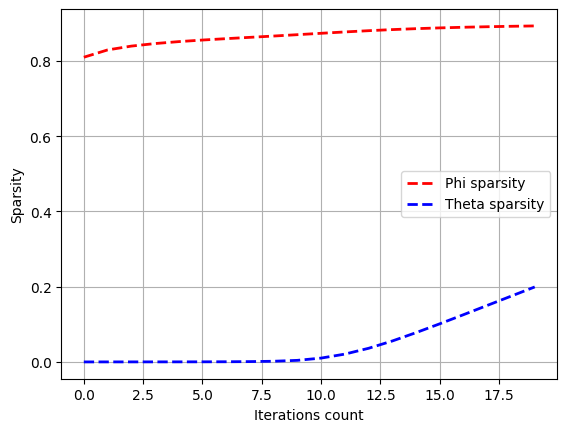

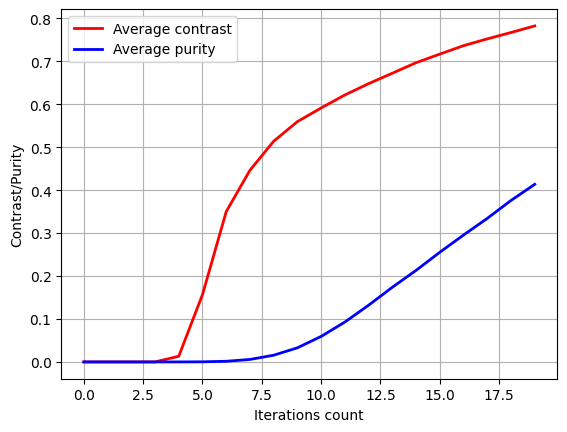

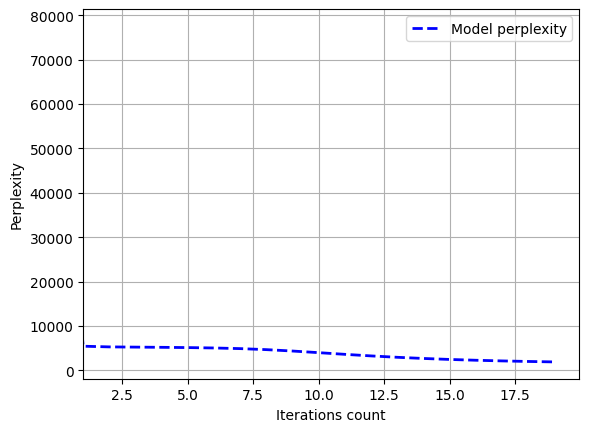

In [14]:
# Перебрав параметры, у нас меньшилась перплексия (чем меньше перплексия, тем лучше)
# Увеличилась чистота и контрастность, что хорошо
print_scores(model_artm.score_tracker, save=None)

In [15]:
def plot_matrix(matrix, figsize=(20,15), xlabel='', ylabel='', title='', save=None):
    plt.figure(figsize=figsize)
    plt.title(title)
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.binary)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.colorbar()
    if save:
        plt.savefig(save, format='eps', dpi=1000, bbox_inches='tight', pad_inches=0)
    print(np.any(np.isnan(matrix)))

In [16]:
theta = model_artm.get_theta().values
phi = model_artm.get_phi().values

False


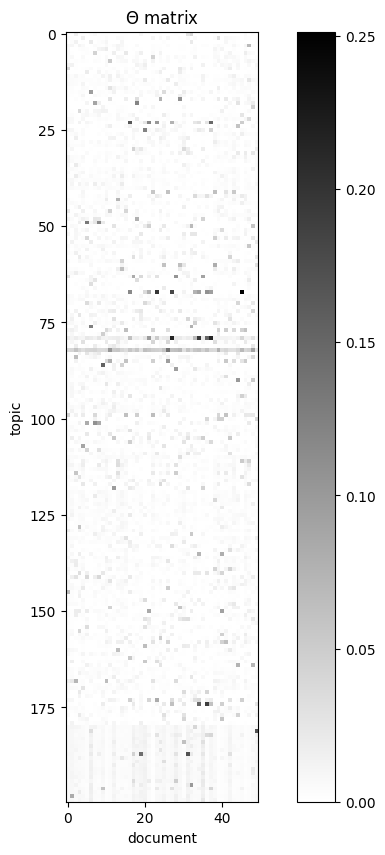

In [18]:
plot_matrix(theta[:,:50], figsize=(10,10), xlabel='document', ylabel='topic',
            title='$\Theta$ matrix', save="Temporal_Theta.eps")

False


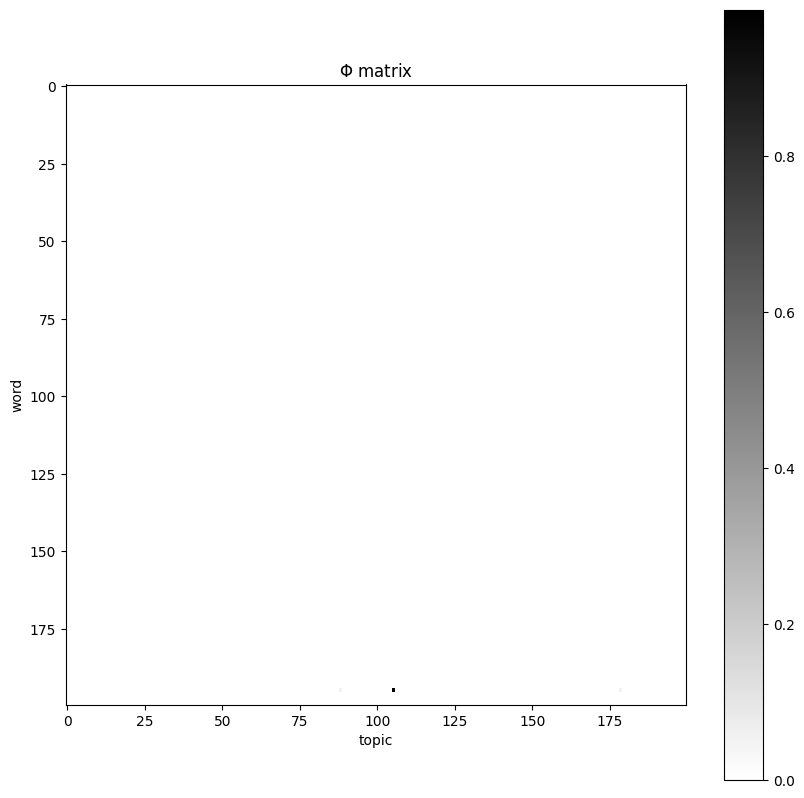

In [20]:
plot_matrix(phi[:200,:], figsize=(10,10), xlabel='topic', ylabel='word',
            title='$\Phi$ matrix', save='Temporal_Phi.eps')

### 6. Eventness

In [24]:
phi_m = model_artm.get_phi(class_ids=[timestamps_class]).values

In [32]:
def get_pyt(phi, t):
    return np.nan_to_num(phi[:, t])


def delta_roc(pyt):
    points = []
    for delta in range(1, pyt.size):
        max_dens = 0
        for pos in range(pyt.size-delta):
            density = np.sum(pyt[pos:pos+delta])
            if density > max_dens:
                max_dens = density
        points.append((delta, 1.0-max_dens))
    return np.array(points)

def auc_delta_roc(delta_roc):
    s = 0
    return np.sum(list(map(lambda x: x[1], delta_roc)))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [33]:
aucs = []
for t in range(parameters['num_topics']):
    aucs.append((auc_delta_roc(delta_roc(get_pyt(phi_m, t)))/73.0, t))

In [134]:
aucs_values = []
for auc in aucs:
  aucs_values.append(auc[0])

In [138]:
top_tokens = []
for topic_name in model_artm.topic_names:
    #print(topic_name + ': ')
    top_tokens.append(', '.join(model_artm.score_tracker['TopTokensScore'].last_tokens[topic_name]))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [140]:
tokens_aucs = dict(zip(top_tokens, aucs_values))

In [157]:
# Для событийных тем Delta-AUC меньше
sorted_tokens_aucs = sorted(tokens_aucs.items(), key=lambda kv: kv[1], reverse=False)
for pair in sorted_tokens_aucs[:10]:
  print('Delta-AUC ' + str(pair[1]) + ': ')
  print(pair[0])

Delta-AUC 0.0: 
лидер, президент, корея, путин, владимир, кндр, ким, глава, заявлять, ноябрь, чен, южный, пхеньян, секретарь, корейский
Delta-AUC 0.0: 
российский, сотрудничество, швеция, финляндия, глава, альянс, апрель, принимать, граница, диалог, укрепление, усилие, заявлять, риа, представитель
Delta-AUC 0.0: 
турция, турецкий, огонь, позиция, эрдоган, анкара, заявлять, территория, гуманитарный, граница, реджеп, тайип, зона, стамбул, действие
Delta-AUC 0.0: 
египет, власть, подавать, решение, брат, организация, назначать, июль, паспорт, сообщать, представитель, египетский, законный, отстранять, мурси
Delta-AUC 0.0: 
больница, тело, скончаться, травма, состояние, скорый, здоровье, водитель, девочка, медицинский, рассказывать, жительница, тяжелый, причина, останки
Delta-AUC 0.0: 
мэр, свобода, комитет, виновный, административный, активист, рф, ответственность, кодекс, статья, городской, незаконный, сообщать, вынести, районный
Delta-AUC 0.0: 
декабрь, алексей, заявлять, миллиардер, рос

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [135]:
topics = sorted(aucs)

In [63]:
eventness_topics = list(map(lambda x: '@topic_' + str(x[1]), topics))

In [64]:
eventness_topicnums = list(map(lambda x: x[1], topics))

<>:2: DeprecationWarning: invalid escape sequence '\X'


True


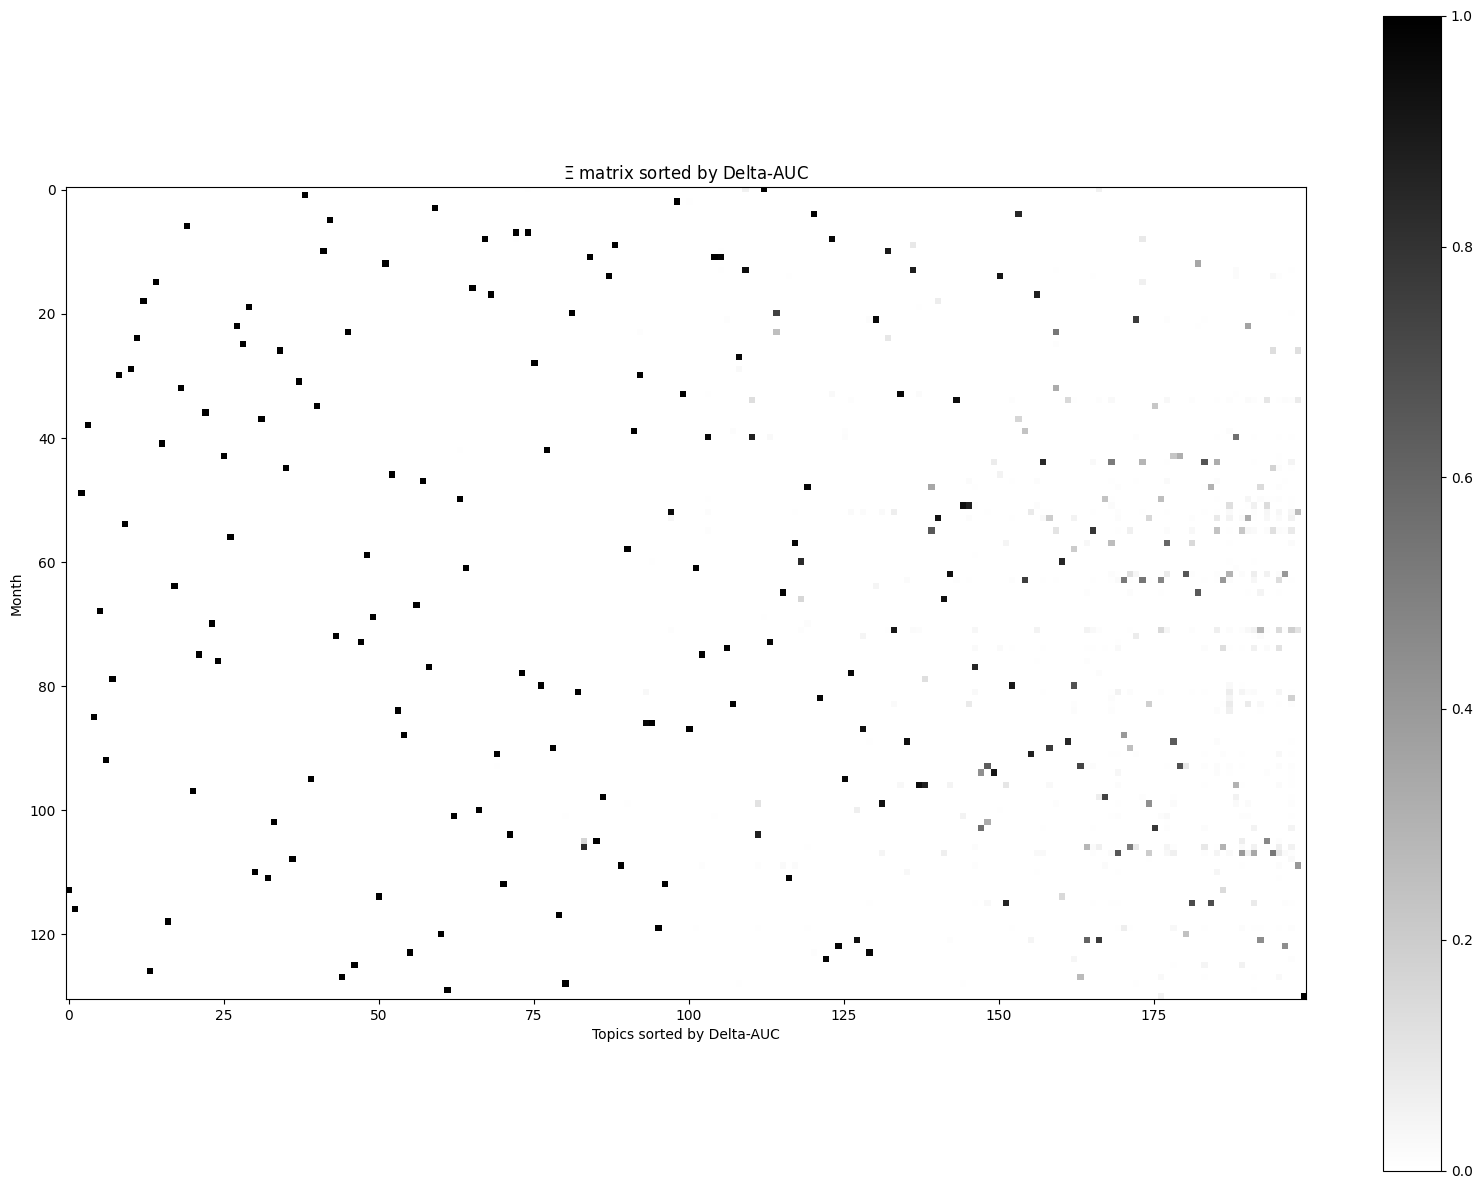

In [51]:
plot_matrix(phi_m[:, eventness_topicnums],
            xlabel='Topics sorted by Delta-AUC', ylabel='Month', title='$\Xi$ matrix sorted by Delta-AUC', save="Temporal_sorted_by_auc_Xi.eps")

In [52]:
eventness_topicnums[:10]

[1, 3, 14, 28, 50, 53, 62, 74, 75, 89]

In [75]:
def print_topics(topic_names=None, weights=False):
    if topic_names is None:
        topic_names = model_artm.topic_names
    for topic_name in topic_names:
        print(topic_name + ': ')
        tokens = model_artm.score_tracker['TopTokensScore'].last_tokens[topic_name]
        if weights:
            weights = model_artm.score_tracker['TopTokensScore'].last_weights[topic_name]
            for token, weight in zip(tokens, weights):
                print("({0}, {1:.3f}), ".format(token, weight))
            print()
        else:
            print(', '.join(tokens))
        print()

In [76]:
print_topics(eventness_topics)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


@topic_1: 
лидер, президент, корея, путин, владимир, кндр, ким, глава, заявлять, ноябрь, чен, южный, пхеньян, секретарь, корейский

@topic_3: 
российский, сотрудничество, швеция, финляндия, глава, альянс, апрель, принимать, граница, диалог, укрепление, усилие, заявлять, риа, представитель

@topic_14: 
турция, турецкий, огонь, позиция, эрдоган, анкара, заявлять, территория, гуманитарный, граница, реджеп, тайип, зона, стамбул, действие

@topic_28: 
египет, власть, подавать, решение, брат, организация, назначать, июль, паспорт, сообщать, представитель, египетский, законный, отстранять, мурси

@topic_50: 
больница, тело, скончаться, травма, состояние, скорый, здоровье, водитель, девочка, медицинский, рассказывать, жительница, тяжелый, причина, останки

@topic_53: 
мэр, свобода, комитет, виновный, административный, активист, рф, ответственность, кодекс, статья, городской, незаконный, сообщать, вынести, районный

@topic_62: 
декабрь, алексей, заявлять, миллиардер, российский, глава, премьер,

In [78]:
eventness_topicnums[-10:]

[63, 193, 21, 189, 179, 180, 192, 197, 73, 15]

In [77]:
def plot_pyt(phi, t, logscale=False, save=None, title=None):
    if not title:
        title = 'Month distribution given @topic{0}'.format(t)
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    pyt = get_pyt(phi, t)
    ax.plot(pyt)
    if logscale:
        ax.set_yscale('log')
    plt.title(title)
    plt.xlabel('y')
    plt.ylabel('p(y $|$ @topic{0})'.format(t))
    plt.ylim(0, 1.0)
    plt.xlim(0, 147)
    plt.grid(True)
    if save:
        plt.savefig(save, format='eps', dpi=1000, bbox_inches='tight', pad_inches=0)

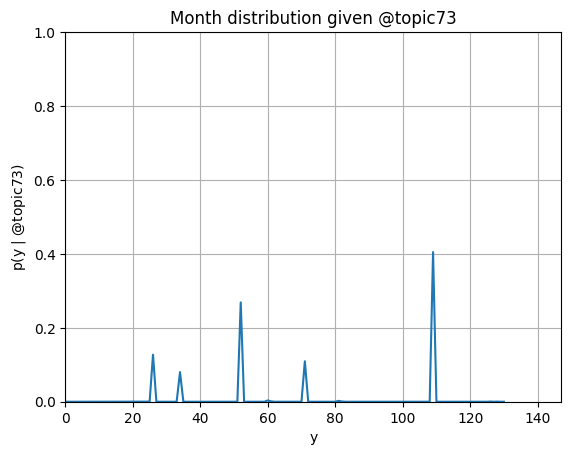

In [79]:
plot_pyt(phi_m, 73, title=None, save=None)

In [100]:
def get_phi_timestamps(model):
    phi_m = model.get_phi(class_ids=[timestamps_class])
    phi_m.index = phi_m.index.map(lambda x: int(x[1]))
    phi_m = phi_m.sort_index()
    return phi_m.values

phi_m = get_phi_timestamps(model_artm)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [104]:
def get_corr_matrix(phi):
    df = pd.DataFrame(phi)
    return df.corr()

phi = model_artm.get_phi(class_ids=[tokens_class]).values
corr_matrix = get_corr_matrix(phi).values

In [116]:
def plot_corr_matrix(matrix, save=None):
    sns.set(style="white")
    sns.set (font_scale = 2)
    f, ax = plt.subplots(figsize=(50, 50))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(matrix, cmap='Greens', vmin=0.0,
            square=True, xticklabels=2, yticklabels=2,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
    ax.set_title('Topic-topic correlation matrix')
    if save:
        plt.savefig(save, format='eps', dpi=1000, bbox_inches='tight', pad_inches=0)

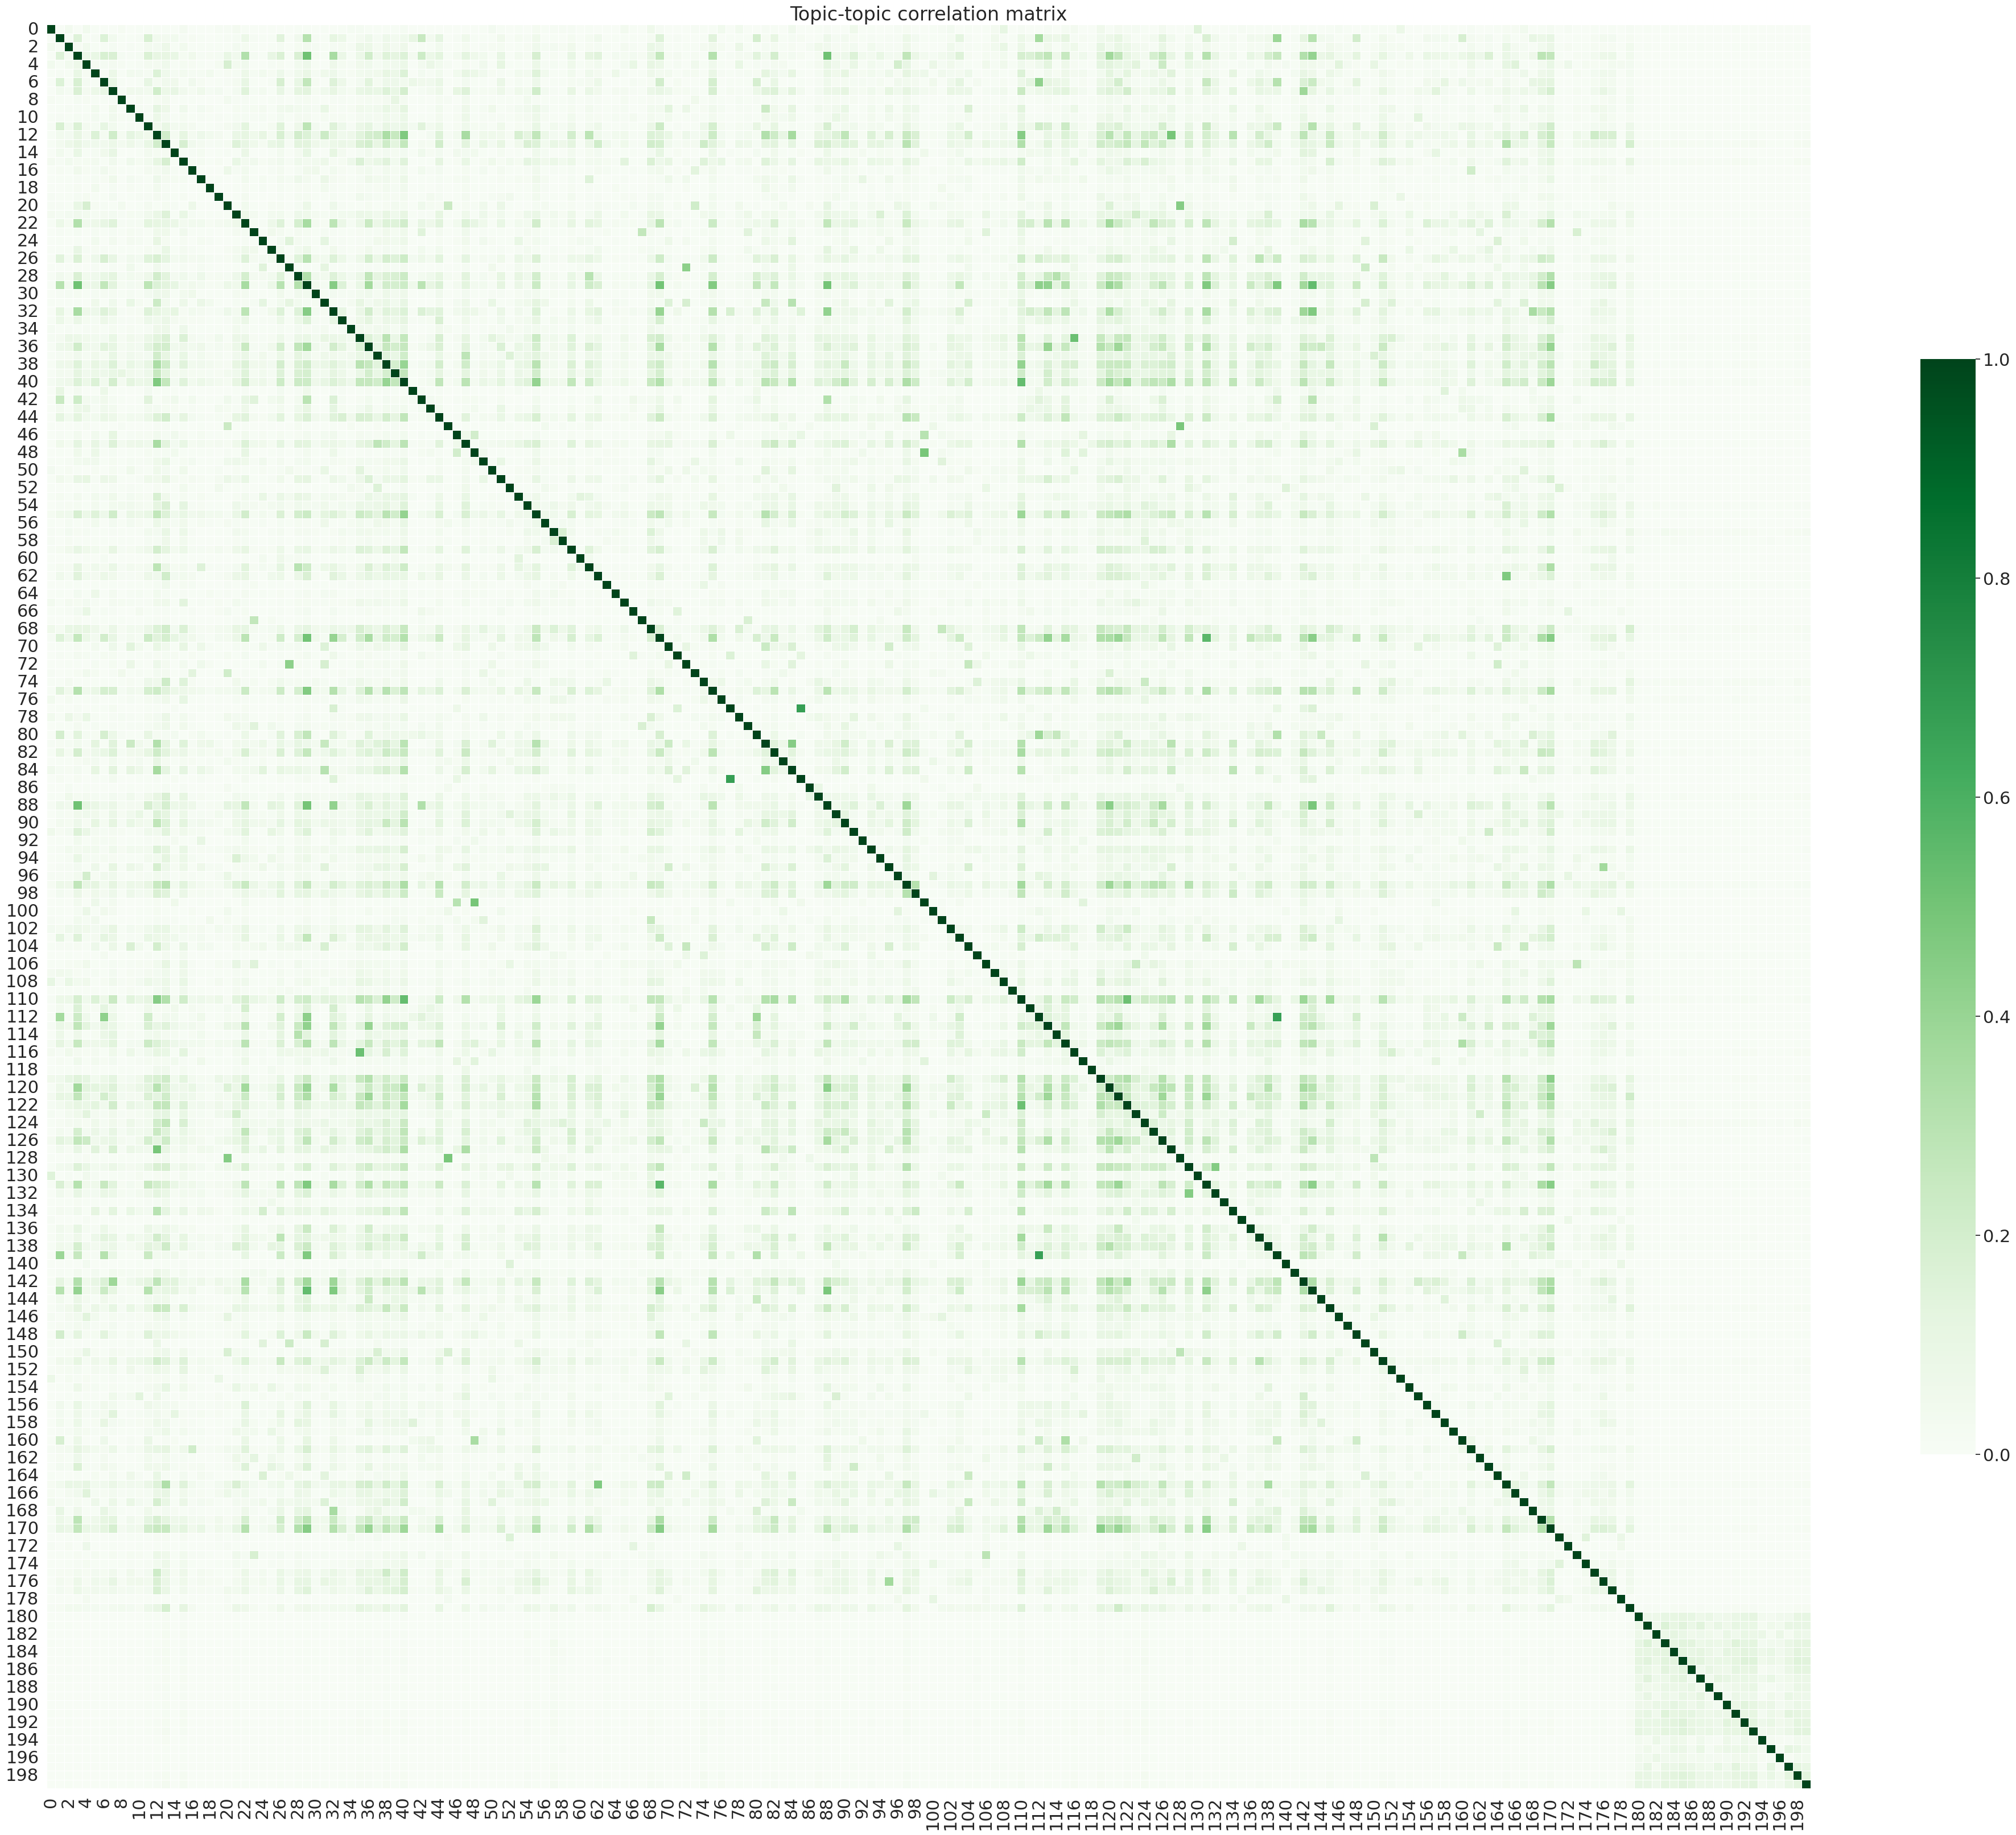

In [117]:
plot_corr_matrix(corr_matrix, save="ARTM_corr.eps")